In [8]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mne.filter import filter_data, notch_filter
from scipy.integrate import trapezoid
from scipy.signal import welch
from antropy import sample_entropy
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 读取数据
raw = mne.io.read_raw_edf("2.edf", preload=True)
annotations = pd.read_csv("2.csv")

# 预处理
raw.filter(0.5, 45, fir_design="firwin")
raw.notch_filter(np.arange(50, 251, 50), fir_design="firwin")
raw.resample(100)

# 创建固定长度事件
events = mne.make_fixed_length_events(raw, duration=30, overlap=15)
epochs = mne.Epochs(raw, events, tmin=0, tmax=30, baseline=None, preload=True)


# 添加睡眠阶段标签
def get_sleep_stage(onset_time, annotations):
    for i in range(len(annotations) - 1):
        if onset_time >= annotations["Onset"].iloc[i] and onset_time < annotations["Onset"].iloc[i + 1]:
            return annotations["Annotation"].iloc[i]
    return annotations["Annotation"].iloc[-1]


epochs.metadata = pd.DataFrame({"onset": events[:, 0] / raw.info["sfreq"], "stage": [get_sleep_stage(e[0] / raw.info["sfreq"], annotations) for e in events]})

# 特征提取
features = []
for i, epoch in enumerate(epochs):
    data = epoch * 1e6  # 转换为μV
    stage = epochs.metadata["stage"].iloc[i]

    # 频域特征
    freqs, psd = welch(data, fs=100, nperseg=256)
    delta = trapezoid(psd[:, (freqs >= 0.5) & (freqs < 4)], freqs[(freqs >= 0.5) & (freqs < 4)])
    theta = trapezoid(psd[:, (freqs >= 4) & (freqs < 8)], freqs[(freqs >= 4) & (freqs < 8)])
    alpha = trapezoid(psd[:, (freqs >= 8) & (freqs < 13)], freqs[(freqs >= 8) & (freqs < 13)])
    beta = trapezoid(psd[:, (freqs >= 13) & (freqs < 30)], freqs[(freqs >= 13) & (freqs < 30)])
    total = delta + theta + alpha + beta
    rel_delta = delta / total
    rel_theta = theta / total
    rel_alpha = alpha / total
    rel_beta = beta / total

    # 非线性特征
    sampen = np.array([sample_entropy(data[j, :], order=2, metric="chebyshev") for j in range(data.shape[0])])

    for ch_idx, ch in enumerate(raw.ch_names):
        features.append({"channel": ch, "stage": stage, "delta": rel_delta[ch_idx], "theta": rel_theta[ch_idx], "alpha": rel_alpha[ch_idx], "beta": rel_beta[ch_idx], "sampen": sampen[ch_idx]})

features_df = pd.DataFrame(features)

Extracting EDF parameters from /home/ethan/Python-Table/EEG/2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7201999  =      0.000 ...  3600.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 13201 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
-

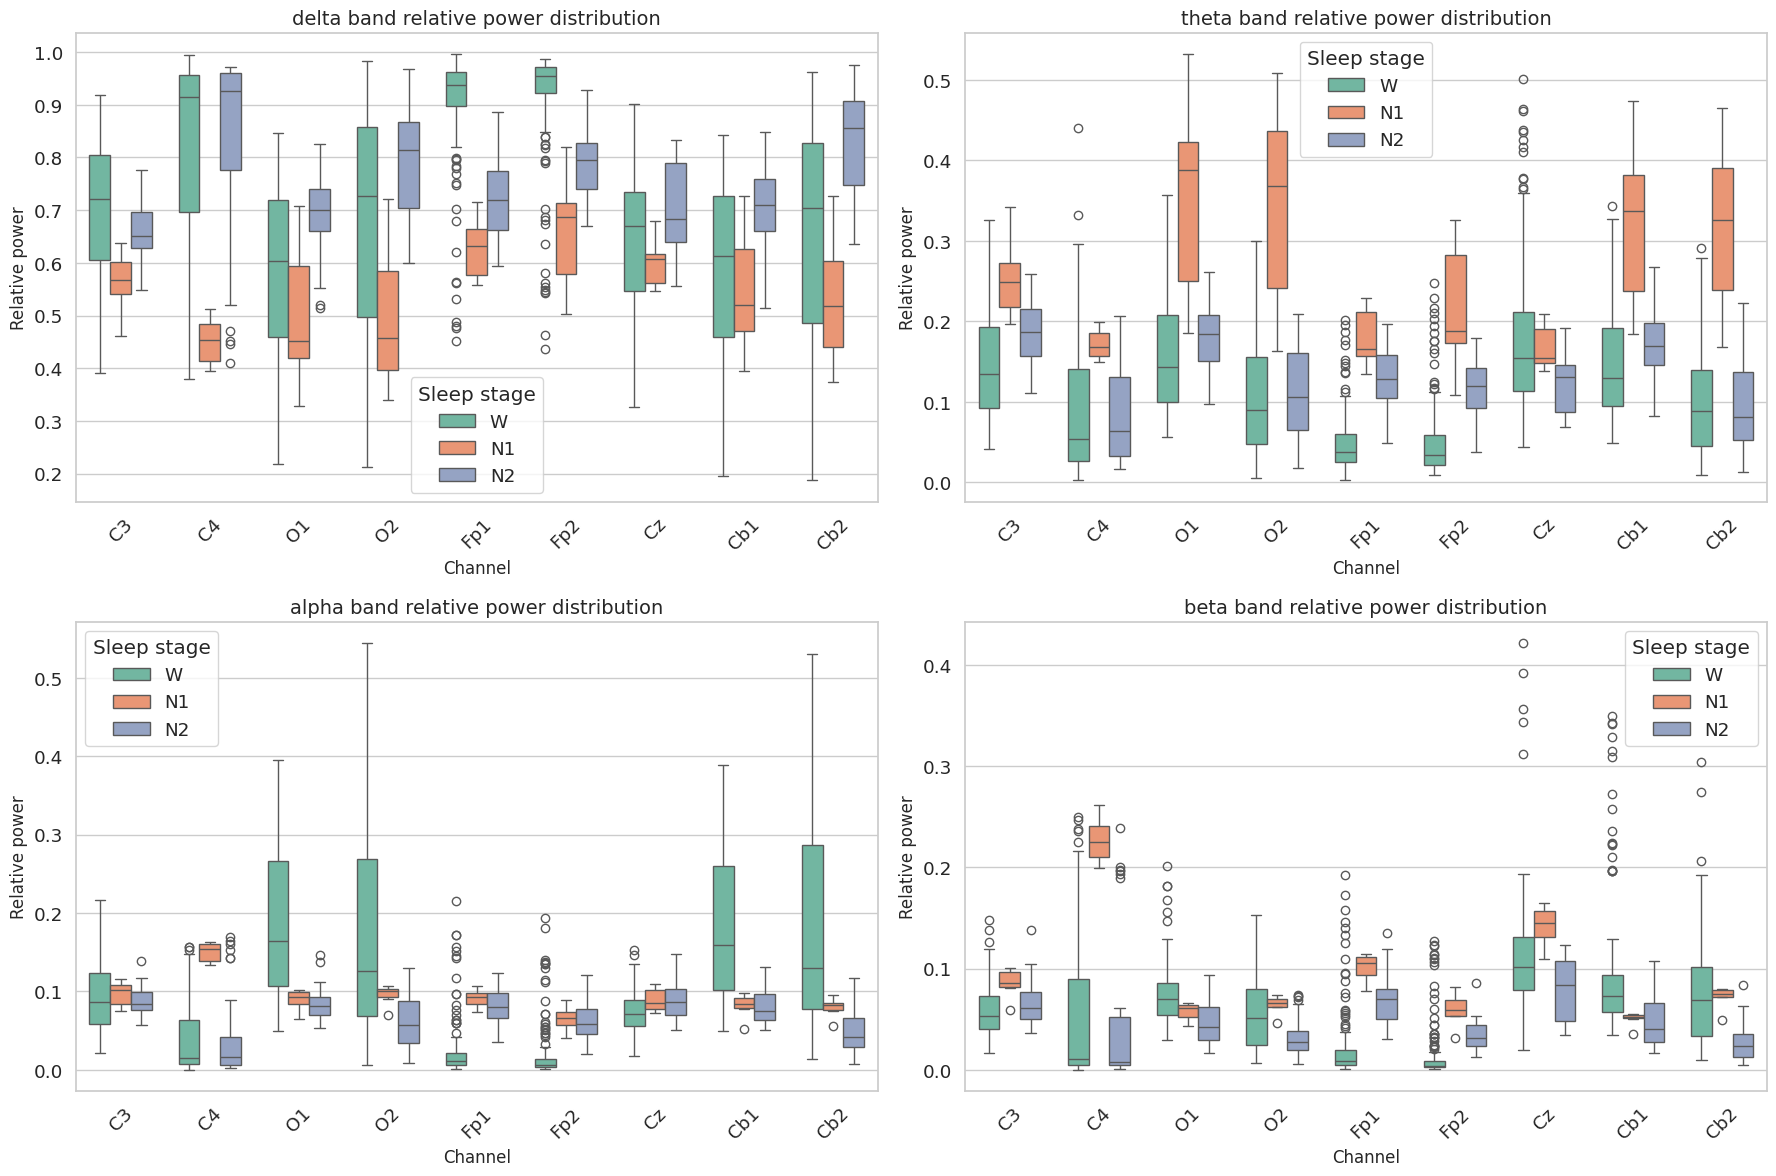

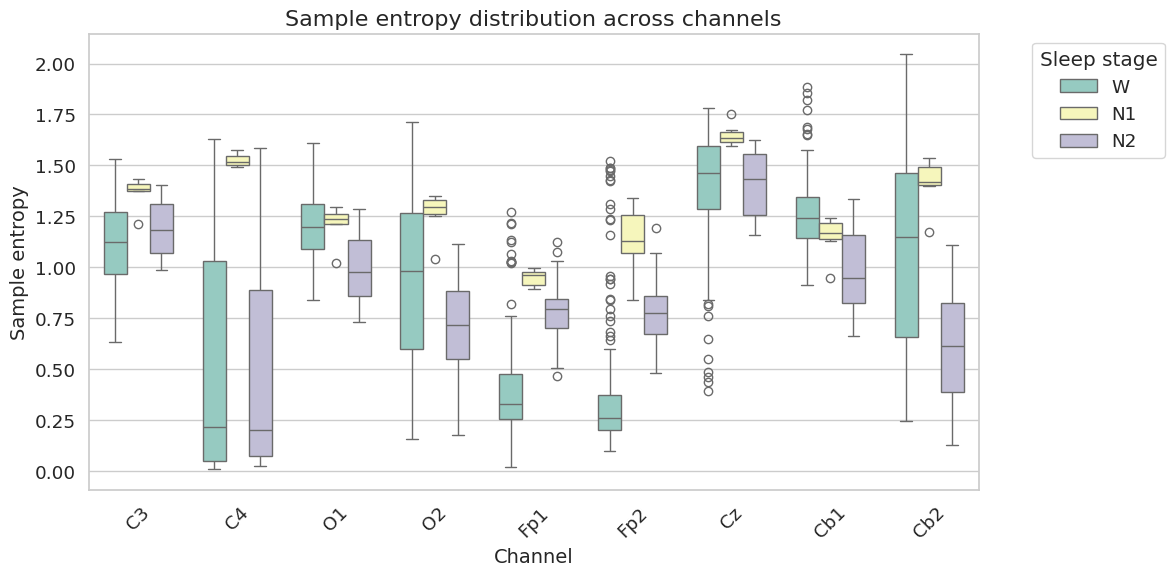

In [12]:
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.2)

# 1. Plot relative power band distributions
plt.figure(figsize=(18, 12))
bands = ["delta", "theta", "alpha", "beta"]

for i, band in enumerate(bands):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x="channel", y=band, hue="stage", data=features_df, order=raw.ch_names, hue_order=["W", "N1", "N2"], palette="Set2", width=0.7)
    plt.title(f"{band} band relative power distribution", fontsize=14)
    plt.xlabel("Channel", fontsize=12)
    plt.ylabel("Relative power", fontsize=12)
    plt.legend(title="Sleep stage")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 2. Plot sample entropy distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x="channel", y="sampen", hue="stage", data=features_df, order=raw.ch_names, hue_order=["W", "N1", "N2"], palette="Set3", width=0.7)
plt.title("Sample entropy distribution across channels", fontsize=16)
plt.xlabel("Channel", fontsize=14)
plt.ylabel("Sample entropy", fontsize=14)
plt.legend(title="Sleep stage", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()